<div style="background-color: #6a513b; padding: 10px;">
  <h1 style="color: #d4c2b2;border-bottom: 2px solid Azure;">Where to open a cafe  in Toronto?</h1>
  <p style="color: #e0d3c7;">This analysis is to find the best neighbourhood in Toronto to open a new cafe . The following aspects are being considered:</p>
  <ul>
    <li style="color: #e0d3c7;">Population density</li>
    <li style="color: #e0d3c7;">Average income</li>
    <li style="color: #e0d3c7;">Proximity to competitors</li>
    <li style="color: #e0d3c7;">What are the other popular businesses in the neighbourhood</li>
  </ul>

  <p style="color: #e0d3c7;">The analysis will be based on the following data sources:</p>
  <ul>
    <li style="color: #e0d3c7;">Wikipedia: To obtain postal code data: <a href="https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M" style="color: Azure; text-decoration: underline;">Wikipedia</a></li>
    <li style="color: #e0d3c7;">Population data CSV: <a href="https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=9810001901" style="color: Azure; text-decoration: underline;">Statistics Canada</a></li>
    <li style="color: #e0d3c7;">Income data CSV: <a href="https://www12.statcan.gc.ca/census-recensement/2021/dp-pd/prof/details/download-telecharger.cfm?Lang=E" style="color: Azure; text-decoration: underline;">Statistics Canada</a> ["Forward sortation areas (FSAs)]</li>
    <li style="color: #e0d3c7;">Google Places API to obtain nearby places data: <a href="https://developers.google.com/maps/documentation/places/web-service/supported_types?_gl=1*gb02v5*_up*MQ..*_ga*MTY4MjAzNTA0MS4xNzMzNjg2NTMz*_ga_NRWSTWS78N*MTczMzY4NjUzMi4xLjEuMTczMzY4Nzk5Ni4wLjAuMA.." style="color: Azure; text-decoration: underline;">Google Nearby Places</a></li>
  </ul>
  <p style="color: #e0d3c7;">Our approach on a high level is:</p>
  <ul>
    <li style="color: #e0d3c7;">Get the postal code data and add latitude and longitudes</li>
    <li style="color: #e0d3c7;">Get income and population data for each postal code/neighbourhood</li>
     <li style="color: #e0d3c7;">Count the number of cafe for each neighbourhood area</li>
    <li style="color: #e0d3c7;">Use the API to get the top 100 Place Types and their Place Type categories within a 500 meter radius of the postal code latitude and longitudes</li>
    <li style="color: #e0d3c7;">Check the frequency of each Place Type category, group them by postal codes, and look at the top 10 most frequent Place Type types to understand the most common business types in each neighbourhood</li>
    <li style="color: #e0d3c7;">Finally, come up with the top 5 neighbourhoods where cafe  competition is low, population is adequate, income is on a higher spectrum, and the other common businesses are not adverse for cafe</li>
  </ul>
</div>

<div style="background-color: #6a513b; padding: 10px;">
  <h3 style="color: #d4c2b2;">Before scrapping and exploring the data, download the dependencies.</h3>
  <p style="color: #e0d3c7;border-top: 2px solid Azure; padding-top: 5px;">Please uncomment the Top lines if you are running this notebook for the first time and then comment them back again</p>
</div>

In [1]:
#!conda install -c conda-forge geopy --yes 
#!pip install geocoder
#!pip install --upgrade pandas pgeocode
#!pip install pgeocode
#!conda install -c conda-forge folium=0.5.0 --yes
import time                                 # For having a time gap in api calls
import pandas as pd                         # For Dataframes, plotting etc
import numpy as np                          # For Mathematical calculation 
import zipfile                              # For unzipping the web scraped files
import os                                   # For correcting the file paths
import requests                             # For geting files and jsons
import json                                 # For reading and wrangling json files
from bs4 import BeautifulSoup               # For scraping html data from websites
from pandas import json_normalize           # For formatting the jsons readable
import folium                               # For plotting maps
import matplotlib.pyplot as plt             # For plotting charts
import matplotlib.cm as cm                  # For functions to handle colormaps
import matplotlib.colors as colors          # For colour maps
import matplotlib.ticker as ticker          # For Grids and tick lables
import pgeocode                             # For getting lat and lon for postal codes
from geopy.geocoders import Nominatim       # For address into latitude and longitude values on maps
from sklearn.cluster import KMeans          # import k-means from clustering stage
import warnings                             # For ignoreing all warnings 
from api_key import google_key              # For importing the API key hidden in the gitignore
from pprint import pprint                   # For printing json
from sklearn.metrics import silhouette_score# For choosing the correct # clusters
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

<div style="background-color: #6a513b; padding: 10px;">
  <h3 style="color: #d4c2b2;">Scrape the postal code data from wikipedia and add Latitude/Longitude for each postal code</h3>
  <p style="color: #e0d3c7;">1.1 - Have pandas read and parse the HTML link: </p>
  <ul>
    <li style="color: #e0d3c7;">Look for the tables to read, on the webpage.</li>
    <li style="color: #e0d3c7;">Choose the table # to create a data frame.</li>
  </ul>
</div>

In [2]:
# Read the data from Wikipedia.
data = pd.read_html("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
# Check how many tables do we find on the html
print(f"We found, {len(data)} table on this HTML webpage")

We found, 3 table on this HTML webpage


In [3]:
# Inspected the webpage and want to scrape the first table in the HTML
wiki = data[0]
wiki

,0,1,2,3,4,5,6,7,8
0,M1A Not assigned,M2A Not assigned,M3A North York (Parkwoods),M4A North York (Victoria Village),M5A Downtown Toronto (Regent Park / Harbourfront),M6A North York (Lawrence Manor / Lawrence Heig...,M7A Queen's Park (Ontario Provincial Government),M8A Not assigned,M9A Etobicoke (Islington Avenue)
1,M1B Scarborough (Malvern / Rouge),M2B Not assigned,M3B North York (Don Mills) North,M4B East York (Parkview Hill / Woodbine Gardens),"M5B Downtown Toronto (Garden District, Ryerson)",M6B North York (Glencairn),M7B Not assigned,M8B Not assigned,M9B Etobicoke (West Deane Park / Princess Gard...
2,M1C Scarborough (Rouge Hill / Port Union / Hig...,M2C Not assigned,M3C North York (Don Mills) South (Flemingdon P...,M4C East York (Woodbine Heights),M5C Downtown Toronto (St. James Town),M6C York (Humewood-Cedarvale),M7C Not assigned,M8C Not assigned,M9C Etobicoke (Eringate / Bloordale Gardens / ...
3,M1E Scarborough (Guildwood / Morningside / Wes...,M2E Not assigned,M3E Not assigned,M4E East Toronto (The Beaches),M5E Downtown Toronto (Berczy Park),M6E York (Caledonia-Fairbanks),M7E Not assigned,M8E Not assigned,M9E Not assigned
4,M1G Scarborough (Woburn),M2G Not assigned,M3G Not assigned,M4G East York (Leaside),M5G Downtown Toronto (Central Bay Street),M6G Downtown Toronto (Christie),M7G Not assigned,M8G Not assigned,M9G Not assigned
5,M1H Scarborough (Cedarbrae),M2H North York (Hillcrest Village),M3H North York (Bathurst Manor / Wilson Height...,M4H East York (Thorncliffe Park),M5H Downtown Toronto (Richmond / Adelaide / King),M6H West Toronto (Dufferin / Dovercourt Village),M7H Not assigned,M8H Not assigned,M9H Not assigned
6,M1J Scarborough (Scarborough Village),M2J North York (Fairview / Henry Farm / Oriole),M3J North York (Northwood Park / York University),M4J East York East Toronto (The Danforth East),M5J Downtown Toronto (Harbourfront East / Unio...,M6J West Toronto (Little Portugal / Trinity),M7J Not assigned,M8J Not assigned,M9J Not assigned
7,M1K Scarborough (Kennedy Park / Ionview / East...,M2K North York (Bayview Village),M3K North York (Downsview) East (CFB Toronto),M4K East Toronto (The Danforth West / Riverdale),M5K Downtown Toronto (Toronto Dominion Centre ...,M6K West Toronto (Brockton / Parkdale Village ...,M7K Not assigned,M8K Not assigned,M9K Not assigned
8,M1L Scarborough (Golden Mile / Clairlea / Oakr...,M2L North York (York Mills / Silver Hills),M3L North York (Downsview) West,M4L East Toronto (India Bazaar / The Beaches W...,M5L Downtown Toronto (Commerce Court / Victori...,M6L North York (North Park / Maple Leaf Park /...,M7L Not assigned,M8L Not assigned,M9L North York (Humber Summit)
9,M1M Scarborough (Cliffside / Cliffcrest / Scar...,M2M North York (Willowdale / Newtonbrook),M3M North York (Downsview) Central,M4M East Toronto (Studio District),M5M North York (Bedford Park / Lawrence Manor ...,M6M York (Del Ray / Mount Dennis / Keelsdale a...,M7M Not assigned,M8M Not assigned,M9M North York (Humberlea / Emery)


<div style="background-color: #6a513b; padding: 10px;">
  <p style="color: #e0d3c7;">1.2 - Read through the Table row by row and store the substrings in separate lists:</p>
  <ul>
    <li style="color: #e0d3c7;">The first 3 Letter are the Postal codes.</li>
    <li style="color: #e0d3c7;">The text after the postal code and before the bracket starts is the Borough Name.</li>
    <li style="color: #e0d3c7;">The text with in the bracket and after the bracket is the Neighbourhood Name.</li>
    <li style="color: #e0d3c7;">Then use the 3 lists to make a dataframe.</li>
  </ul>
</div>

In [4]:
# Creating a function to loop through the html table and store the values in a separate  lists
def get_first_three_chars_and_substring(wiki):
    # Create empty lists to store the results
    postalcode_list = []
    borough_list = []
    neighborhood_list = []

    # Iterate through each column in the DataFrame
    for col in wiki:
        # Retrieve the first 3 characters of each string in the column and store in a list
        col_values = wiki[col].astype(str).apply(lambda x: x[:3]).tolist()
        postalcode_list.append(col_values)

        # Retrieve the substring from the 4th place value till the bracket open symbol "("
        substr_values = wiki[col].astype(str).apply(lambda x: x[4:x.find(' (')] if ' (' in x else x[4:]).tolist()
        borough_list.append(substr_values)

        # Retrieve the values within the brackets
        bracket_values = wiki[col].astype(str).apply(lambda x: x[x.find('(')+1:x.find(')')] if '(' in x and ')' in x else '').tolist()
        neighborhood_list.append(bracket_values)

    return postalcode_list, borough_list, neighborhood_list

# Get the first 3 characters, substrings, and bracket values of each column and store in separate lists
postalcode_list, borough_list, neighborhood_list = get_first_three_chars_and_substring(wiki)

# Flatten the lists
postalcode_flat = [item for sublist in postalcode_list for item in sublist]
borough_flat = [item for sublist in borough_list for item in sublist]
neighborhood_flat = [item for sublist in neighborhood_list for item in sublist]

# Create a DataFrame
toronto = pd.DataFrame({
    'Postal Code': postalcode_flat,
    'Borough': borough_flat,
    'Neighborhood': neighborhood_flat
})

# Drop rows where the column "Borough" has the value "Not assigned"
toronto = toronto[toronto['Borough'] != 'Not assigned']

# Display the resulting DataFrame
toronto.info()
toronto.head()

<class 'pandas.core.frame.DataFrame'>
Index: 103 entries, 1 to 176
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Postal Code   103 non-null    object
 1   Borough       103 non-null    object
 2   Neighborhood  103 non-null    object
dtypes: object(3)
memory usage: 3.2+ KB


,Postal Code,Borough,Neighborhood
1,M1B,Scarborough,Malvern / Rouge
2,M1C,Scarborough,Rouge Hill / Port Union / Highland Creek
3,M1E,Scarborough,Guildwood / Morningside / West Hill
4,M1G,Scarborough,Woburn
5,M1H,Scarborough,Cedarbrae


<div style="background-color: #6a513b; padding: 10px;">
  <p style="color: #e0d3c7;">1.3 - Add latitude and longitude for each postal code.</p>
</div>

In [5]:
# Create a Nominatim instance for Canada
nomi = pgeocode.Nominatim('CA')

# Create new columns for latitude and longitude
toronto['Latitude'] = None
toronto['Longitude'] = None

# Iterate over each row to get the latitude and longitude
for index, row in toronto.iterrows():
    location = nomi.query_postal_code(row['Postal Code'])
    toronto.at[index, 'Latitude'] = location.latitude
    toronto.at[index, 'Longitude'] = location.longitude


# Display the updated DataFrame
display(toronto.info())
display(toronto.head())

<class 'pandas.core.frame.DataFrame'>
Index: 103 entries, 1 to 176
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Postal Code   103 non-null    object
 1   Borough       103 non-null    object
 2   Neighborhood  103 non-null    object
 3   Latitude      102 non-null    object
 4   Longitude     102 non-null    object
dtypes: object(5)
memory usage: 8.9+ KB


None

,Postal Code,Borough,Neighborhood,Latitude,Longitude
1,M1B,Scarborough,Malvern / Rouge,43.8113,-79.193
2,M1C,Scarborough,Rouge Hill / Port Union / Highland Creek,43.7878,-79.1564
3,M1E,Scarborough,Guildwood / Morningside / West Hill,43.7678,-79.1866
4,M1G,Scarborough,Woburn,43.7712,-79.2144
5,M1H,Scarborough,Cedarbrae,43.7686,-79.2389


<div style="background-color: #6a513b; padding: 10px;">
  <p style="color: #e0d3c7;">1.4 - Inspect and Clean up the data.</p>
  <ul>
    <li style="color: #e0d3c7;">Reset the index.</li>
    <li style="color: #e0d3c7;">Look for Nulls</li>
    <li style="color: #e0d3c7;">Drop nulls and the Postal codes which are just "Enclave" of other postal codes</li>
  </ul>
</div>

In [6]:
toronto=toronto.reset_index(drop=True)
toronto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Postal Code   103 non-null    object
 1   Borough       103 non-null    object
 2   Neighborhood  103 non-null    object
 3   Latitude      102 non-null    object
 4   Longitude     102 non-null    object
dtypes: object(5)
memory usage: 4.1+ KB


In [7]:
rows_with_null = toronto[toronto.isnull().any(axis=1)]
rows_with_null

,Postal Code,Borough,Neighborhood,Latitude,Longitude
86,M7R,Mississauga Canada Post Gateway Processing Centre,Enclave of L4W,NaN,NaN


In [8]:
toronto_df = toronto.dropna(subset=['Latitude'])
toronto_df = toronto_df[~toronto_df['Neighborhood'].str.startswith('Enclave')].reset_index(drop=True)
toronto_df.info()
toronto_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Postal Code   100 non-null    object
 1   Borough       100 non-null    object
 2   Neighborhood  100 non-null    object
 3   Latitude      100 non-null    object
 4   Longitude     100 non-null    object
dtypes: object(5)
memory usage: 4.0+ KB


,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,Malvern / Rouge,43.8113,-79.193
1,M1C,Scarborough,Rouge Hill / Port Union / Highland Creek,43.7878,-79.1564
2,M1E,Scarborough,Guildwood / Morningside / West Hill,43.7678,-79.1866
3,M1G,Scarborough,Woburn,43.7712,-79.2144
4,M1H,Scarborough,Cedarbrae,43.7686,-79.2389


 <div style="background-color: #6a513b; padding: 10px;">
  <p style="color: #e0d3c7;">1.5 - Save the cleaned data in a dataframe which stores the exploded form of the Neighbourhood column (where we see that many to one relation between the psotal code and neighbourhoods).</p>
</div>

In [9]:
# Creating a Neighbourhood specific dataframe
toronto_df_n = pd.DataFrame(toronto_df)

# Split the strings in the third column and expand into separate rows
toronto_df_n['Neighborhood'] = toronto_df_n['Neighborhood'].str.split('/')
toronto_df_n = toronto_df_n.explode('Neighborhood').reset_index(drop=True)

toronto_df_n.info()
toronto_df_n.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Postal Code   212 non-null    object
 1   Borough       212 non-null    object
 2   Neighborhood  212 non-null    object
 3   Latitude      212 non-null    object
 4   Longitude     212 non-null    object
dtypes: object(5)
memory usage: 8.4+ KB


,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,Malvern,43.8113,-79.193
1,M1B,Scarborough,Rouge,43.8113,-79.193
2,M1C,Scarborough,Rouge Hill,43.7878,-79.1564
3,M1C,Scarborough,Port Union,43.7878,-79.1564
4,M1C,Scarborough,Highland Creek,43.7878,-79.1564


<div style="background-color: #6a513b; padding: 10px;">
<p style="color: #e0d3c7;">2.1 - Get the Population data for each postal code.</p>
<ul>
    <li style="color: #e0d3c7;">Read the csv obtained from stats canada website.</li>
    <li style="color: #e0d3c7;">Collect the row where the "Geographic name" column starts with "M", as all postal codes of Toronto start with "M".</li>
  </ul>
</div>

In [10]:
# Path to the downloaded population file
path_population = 'extracted_files/population_data_2021.csv'

# Read the CSV file into a DataFrame
population = pd.read_csv(path_population)

# Filter rows where the values in the "Geographic name" column start with "M"
population_df = population[population['Geographic name'].str.startswith('M')]

# Display the filtered DataFrame
population_df = population_df.rename(columns={'Geographic name':'Postal Code'}).astype(str)
population_df['Population, 2021'] = population_df['Population, 2021'].str.replace(',', '').astype(int)
population_df['Total private dwellings, 2021'] = population_df['Total private dwellings, 2021'].str.replace(',', '').astype(int)
population_df['Private dwellings occupied by usual residents, 2021'] = population_df['Private dwellings occupied by usual residents, 2021'].str.replace(',', '').astype(int)
population_df = population_df.loc[:, ['Postal Code', 'Population, 2021']].reset_index(drop=True)
population_df.info()
population_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Postal Code       97 non-null     object
 1   Population, 2021  97 non-null     int32 
dtypes: int32(1), object(1)
memory usage: 1.3+ KB


,Postal Code,"Population, 2021"
0,M1B,65555
1,M1C,35642
2,M1E,48033
3,M1G,30894
4,M1H,23964


 <div style="background-color: #6a513b; padding: 10px;">
  <p style="color: #e0d3c7;" >3.1 - Get income data for each postal code.</p>
  <ul>
    <li style="color: #e0d3c7;">Read the original large csv line by line and for line where GEO_NAME and GEO_CODE (POR) starts with "M" retain those and writing them into a new csv as output.</li>
  </ul>
</div>

 <div style="background-color: #6a513b; padding: 10px;">
  <p style="color: #e0d3c7;" >The Cell Below is commented out as the stats canada csv file was very very large and we extracted the Toronto specific (Postal code M%), saving it as income_data_2021, this was done on a local machine</p>
</div>

In [11]:
# # Path to the CSV file
# income_load = '../98-401-X2021013_English_CSV_data.csv'

# # Read the CSV file with a different encoding
# income_load_df = pd.read_csv(income_load, encoding='latin1')

# # Convert 'ALT_GEO_CODE' and 'GEO_NAME' columns to strings
# income_load_df['ALT_GEO_CODE'] = income_load_df['ALT_GEO_CODE'].astype(str)
# income_load_df['GEO_NAME'] = income_load_df['GEO_NAME'].astype(str)

# # Filter rows where the value in 'ALT_GEO_CODE' or 'GEO_NAME' starts with "M"
# toronto_income_df = income_load_df[income_load_df['ALT_GEO_CODE'].str.startswith('M', na=False) | income_load_df['GEO_NAME'].str.startswith('M', na=False)]

# # Save the filtered DataFrame as a CSV file
# toronto_income_df.to_csv('extracted_files/income_data_2021.csv', index=False)

# # Display the result
# toronto_income_df.info()

<div style="background-color: #6a513b; padding: 10px;">
  <p style="color: #e0d3c7;">3.2- Read through the extracted csv  and create a dataframe having Postal code and Household Income</p>
  <ul>
    <li style="color: #e0d3c7;">Read the CSV row by row and collect the rows where where column named "DIM: Profile of Forward Sortation Areas (2247)" has the value "Median total income of households in 2015 ($)"</li>
    <li style="color: #e0d3c7;">For the collected rows get the value from column "GEO_NAME', 'Dim: Sex (3): Member ID: [1]: Total - Sex" </li>
    <li style="color: #e0d3c7;">Create a dataframe with GEO_NAME as postal code and "GEO_NAME', 'Dim: Sex (3): Member ID: [1]: Total - Sex" as Household Income.</li>
  </ul>
</div>

In [12]:
# Path to the CSV file
path_income = 'extracted_files/income_data_2021.csv'

# Value to match
find_in_rows = '  Median total income of household in 2020 ($)'

# Read the CSV file
dfi = pd.read_csv(path_income)

# Filter rows where the value in a specific column matches the given value
income_df = dfi[dfi['CHARACTERISTIC_NAME'] == find_in_rows]

# Select only the desired columns
income_df = income_df[['GEO_NAME', 'C1_COUNT_TOTAL']].reset_index(drop=True)

# Rename the columns
income_df = income_df.rename(columns={
    'GEO_NAME': 'Postal Code',
    'C1_COUNT_TOTAL': 'Household Income'
})

# Convert 'Household Income' to numeric, coercing errors to NaN
income_df['Household Income'] = pd.to_numeric(income_df['Household Income'], errors='coerce')

# Drop rows with NaN values in 'Household Income'
income_df = income_df.dropna(subset=['Household Income']).reset_index(drop=True)

# Convert 'Household Income' to int
income_df['Household Income'] = income_df['Household Income'].astype(int)

# Display the result
income_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Postal Code       96 non-null     object
 1   Household Income  96 non-null     int32 
dtypes: int32(1), object(1)
memory usage: 1.2+ KB


 <div style="background-color: #6a513b; padding: 10px;">
  <p style="color: #e0d3c7;" >4.1 - Merge the Postal codes, Lat, Lon, Population, Income in one clean dataframe.</p>
  <ul>
    <li style="color: #e0d3c7;">Merge the 3 data frames and look for the rows that missing in among the intersection using "indicator"</li>
    <li style="color: #e0d3c7;">We found that postal codes - M5K, M5L, M5X are office blocks and M7A is Canadian Parliament building, these do not have income or population data. We can drop these in our Postal, income and population data frames and merge them.</li>
    <li style="color: #e0d3c7;">Drop these postal codes.</li>
    <li style="color: #e0d3c7;">Look for duplicates and finally have a clean data frame with postal code Household Income and population.</li>
  </ul>
</div>

In [13]:
# Merge toronto_df and population_df
toronto_population = toronto_df.merge(population_df, on='Postal Code', how='outer', indicator='merge_df1_df2')

# Merge the result with income_df
toronto_population_income = toronto_population.merge(income_df, on='Postal Code', how='outer', indicator='merge_all', suffixes=('_df1_df2', '_df3'))

# Find rows that are missing in either of the DataFrames
missing_rows = toronto_population_income[(toronto_population_income['merge_df1_df2'] != 'both') | (toronto_population_income['merge_all'] != 'both')]

missing_rows


,Postal Code,Borough,Neighborhood,Latitude,Longitude,"Population, 2021",merge_df1_df2,Household Income,merge_all
60,M5K,Downtown Toronto,Toronto Dominion Centre / Design Exchange,43.6469,-79.3823,NaN,left_only,NaN,left_only
61,M5L,Downtown Toronto,Commerce Court / Victoria Hotel,43.6492,-79.3823,NaN,left_only,NaN,left_only
69,M5X,Downtown Toronto,First Canadian Place / Underground city,43.6492,-79.3823,NaN,left_only,NaN,left_only
84,M7A,Queen's Park,Ontario Provincial Government,43.6641,-79.3889,5.0,both,NaN,left_only


In [14]:
# Merge toronto_df and population_df
toronto_population = toronto_df.merge(population_df, on='Postal Code', how='outer', indicator='merge_df1_df2')

# Merge the result with income_df
toronto_population_income = toronto_population.merge(income_df, on='Postal Code', how='outer', indicator='merge_all', suffixes=('_df1_df2', '_df3'))

# Find rows that are present in all three DataFrames
intersection_rows = toronto_population_income[(toronto_population_income['merge_df1_df2'] == 'both') & (toronto_population_income['merge_all'] == 'both')]

# Find rows that are missing in either of the DataFrames
missing_rows = toronto_population_income[(toronto_population_income['merge_df1_df2'] != 'both') | (toronto_population_income['merge_all'] != 'both')]

# Exclude missing_rows from intersection_rows based on 'Postal Code'
toronto_data = intersection_rows[~intersection_rows['Postal Code'].isin(missing_rows['Postal Code'])].reset_index(drop=True)

# Display the result
toronto_data = toronto_data.drop(columns=['merge_df1_df2', 'merge_all']).rename(columns={'Population, 2021': 'Population'})

toronto_data.info()
toronto_data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Postal Code       96 non-null     object 
 1   Borough           96 non-null     object 
 2   Neighborhood      96 non-null     object 
 3   Latitude          96 non-null     object 
 4   Longitude         96 non-null     object 
 5   Population        96 non-null     float64
 6   Household Income  96 non-null     float64
dtypes: float64(2), object(5)
memory usage: 5.4+ KB


,Postal Code,Borough,Neighborhood,Latitude,Longitude,Population,Household Income
0,M1B,Scarborough,Malvern / Rouge,43.8113,-79.193,65555.0,91000.0
1,M1C,Scarborough,Rouge Hill / Port Union / Highland Creek,43.7878,-79.1564,35642.0,130000.0
2,M1E,Scarborough,Guildwood / Morningside / West Hill,43.7678,-79.1866,48033.0,82000.0
3,M1G,Scarborough,Woburn,43.7712,-79.2144,30894.0,73500.0
4,M1H,Scarborough,Cedarbrae,43.7686,-79.2389,23964.0,80000.0


In [15]:
# Looking for more duplicates of latitude and longitude 
toronto_combined_duplicates = toronto_data[toronto_df.duplicated()]

if toronto_combined_duplicates.empty: 
    print("No duplicates found")
else: 
    print(toronto_combined_duplicates)

No duplicates found


 <div style="background-color: #6a513b; padding: 10px;">
  <p style="color: #e0d3c7;" >5.1 - Plotting a Pie Chart to explore the Top 10 Populous Neighbourhoods in Toronto.</p>
</div>

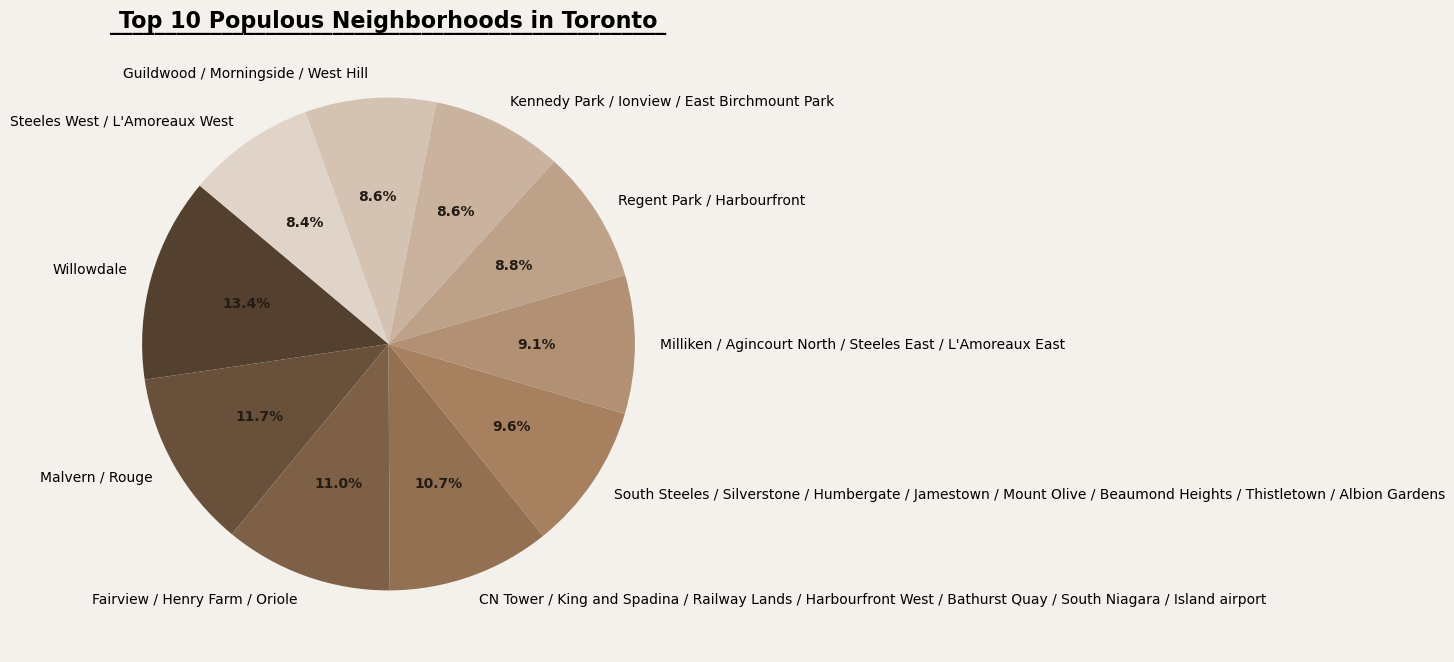

In [16]:
# Plot the top population postal codes/Neighborhoods.
toronto_income_p = toronto_data[['Postal Code', 'Neighborhood', 'Population']]
sorted_toronto_income_p = toronto_income_p.sort_values(by='Population', ascending=False)
t10_sorted_toronto_income_p = sorted_toronto_income_p.head(10)

# Applying cafe theme
colors = ['#E0D3C7', '#D4C2B2', '#C9B29E', '#BDA189', '#B19074', '#A6805F',
          '#927051', '#7D6046', '#68503A', '#53402E'][::-1]  # Reverse the color order

fig, ax = plt.subplots(figsize=(12,8), subplot_kw=dict(aspect="equal"))
fig.patch.set_facecolor('#F4F0EC')  # Set the background color

# Create a pie chart
wedges, texts, autotexts = ax.pie(t10_sorted_toronto_income_p['Population'],
                                  labels=t10_sorted_toronto_income_p['Neighborhood'],
                                  colors=colors[:len(t10_sorted_toronto_income_p)],
                                  autopct='%1.1f%%',
                                  startangle=140)

# Add a title
plt.title('Top 10 Populous Neighborhoods in Toronto', fontsize=16, fontweight='bold')

# Add a line below the title to create an underline effect
plt.text(0.5, 1.01, '__________________________________________________', horizontalalignment='center', fontsize=16, fontweight='bold', transform=ax.transAxes)

# Customize the appearance of the percentage labels
for autotext in autotexts:
    autotext.set_color('#241c14')
    autotext.set_fontsize(10)
    autotext.set_fontweight('bold')

plt.show()

 <div style="background-color: #6a513b; padding: 10px;">
  <p style="color: #e0d3c7;" >5.2 - Plotting a Bar Chart to explore the Top 10 Rich Neighbourhoods in Toronto.</p>
</div>

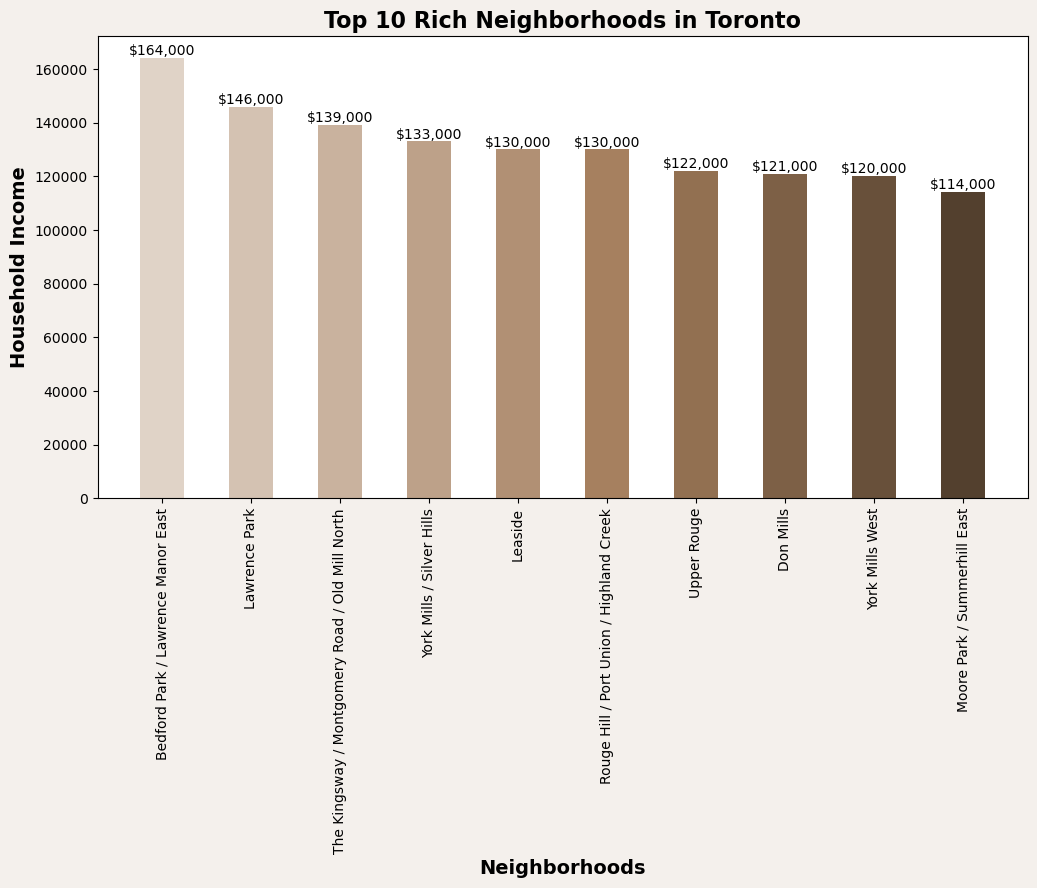

In [17]:
# Plot the top income postal codes/Neighborhoods.
toronto_income_i = toronto_data[['Postal Code', 'Neighborhood', 'Household Income']]
sorted_toronto_income_i = toronto_income_i.sort_values(by='Household Income', ascending=False)
t20_sorted_toronto_income_i = sorted_toronto_income_i.head(10)
# Applying cafe theme
colors = ['#E0D3C7', '#D4C2B2', '#C9B29E', '#BDA189', '#B19074', '#A6805F',
          '#927051', '#7D6046', '#68503A', '#53402E']
fig, ax = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('#F4F0EC')  # Set the background color
bars = plt.bar(t20_sorted_toronto_income_i['Neighborhood'],
               t20_sorted_toronto_income_i['Household Income'],
               color=colors[:len(t20_sorted_toronto_income_i)],
               width=0.5)  # Adjust the width to increase the gap
# Setting bar labels
for bar, income in zip(bars, t20_sorted_toronto_income_i['Household Income']):
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # Center text horizontally on bar
        bar.get_height() + 0,  # Position text on the bar
        f"${income:,.0f}",  # Format income as currency
        ha='center',
        va='bottom',
        fontsize=10
    )
# Add titles and labels
plt.title('Top 10 Rich Neighborhoods in Toronto', fontsize=16, fontweight='bold')
plt.xlabel('Neighborhoods', fontsize=14, fontweight='bold')
plt.ylabel('Household Income', fontsize=14, fontweight='bold')
# Rotate x-axis labels by 90 degrees
plt.xticks(rotation=90)
plt.show()

 <div style="background-color: #6a513b; padding: 10px;">
  <p style="color: #e0d3c7;" >6.1 - Using the Google Nearby Places API to look for cafe with in 500 meters of each post code Latitude/longitude and count them.</p>
  <ul>
    <li style="color: #e0d3c7;">Set up base url for API call</li>
    <li style="color: #e0d3c7;">Test and inspect the json response</li>
    <li style="color: #e0d3c7;">Create a function to get all cafe in the given parameters.</li>
    <li style="color: #e0d3c7;">Use the function to get all cafes for each postal code and count them</li>
    <li style="color: #e0d3c7;">Add the cafe names and cafe counts to totonto_data</li>
    <li style="color: #e0d3c7;">Write toronto_data as a csv and then read it back again as totonto_data_df so that we do not have to make the API calls when we run the notebook again.</li>
  </ul>
</div>

In [18]:
# Base URL for Google Places API
base_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"

In [19]:
# Define the URL and parameters
base_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"
test_params = {
    "keyword": "coffee",
    "location": "43.6966,-79.412",
    "radius": 1500,
    "type": "cafe",
    "key": google_key,
}

# Make the request
test_response = requests.get(base_url, params=test_params)

# Check if the request was successful
if test_response.status_code == 200:
    data = test_response.json()
    # Print only the first result
    if data['results']:
        first_result = data['results'][0]
        pprint(first_result)
    else:
        print("No results found.")
else:
    pprint(f"Failed to fetch data: {test_response.status_code}, {test_response.text}")


{'business_status': 'OPERATIONAL',
 'geometry': {'location': {'lat': 43.6879306, 'lng': -79.3935557},
              'viewport': {'northeast': {'lat': 43.68938212989273,
                                         'lng': -79.39239787010727},
                           'southwest': {'lat': 43.68668247010728,
                                         'lng': -79.39509752989271}}},
 'icon': 'https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/cafe-71.png',
 'icon_background_color': '#FF9E67',
 'icon_mask_base_uri': 'https://maps.gstatic.com/mapfiles/place_api/icons/v2/cafe_pinlet',
 'name': 'Pilot Coffee Roasters',
 'opening_hours': {'open_now': True},
 'photos': [{'height': 3024,
             'html_attributions': ['<a '
                                   'href="https://maps.google.com/maps/contrib/116139881992485386711">A '
                                   'Google User</a>'],
             'photo_reference': 'AdDdOWqEaZnUHDKfKWp4qGGzhubkHDUliDg7y04X6_OpzELP5KuxtXiGLzQifgkvdVSwf0yY0CKb

 <div style="background-color: #6a513b; padding: 10px;">
  <p style="color: #e0d3c7;" >The Cell Below is commented out as it was used to make the API calls and then write the results in a csv. Google only allows limited number of free API calls.</p>
</div>

In [20]:
# # Function to get places using Google Places API
# def get_places_cafe(latitude, longitude, radius=500, place_type="cafe", base_url=base_url):
#     params = {
#         "location": f"{latitude},{longitude}",
#         "radius": radius,
#         "type": place_type,
#         "key": google_key,
#         "limit": 50  # Limit to 50 results
#     }
#     all_cafe = []
#     while True:
#         response = requests.get(base_url, params=params)
#         if response.status_code == 200:
#             data = response.json()
#             places = data.get('results', [])
#             all_cafe.extend(places)
#             next_page_token = data.get('next_page_token')
#             if next_page_token:
#                 params['pagetoken'] = next_page_token
#                 # Google recommends waiting a few seconds before making the next request
#                 time.sleep(2)
#             else:
#                 break
#         else:
#             print(f"Failed to fetch data: {response.status_code}, {response.json()}")
#             break
#     place_names = [place['name'] for place in all_cafe]
#     return len(place_names), place_names

 <div style="background-color: #6a513b; padding: 10px;">
  <p style="color: #e0d3c7;" >The Cell Below is commented out as it was used to make the API calls and then write the results in a csv. Google only allows limited number of free API calls.</p>
</div>

In [21]:
# # Create a Nominatim instance for Canada
# nomi = pgeocode.Nominatim('CA')

# # Create new columns for latitude and longitude in the original DataFrame
# toronto_data['Latitude'] = None
# toronto_data['Longitude'] = None

# # Iterate over each row to get the latitude and longitude
# for index, row in toronto_data.iterrows():
#     location = nomi.query_postal_code(row['Postal Code'])
#     toronto_data.at[index, 'Latitude'] = location.latitude
#     toronto_data.at[index, 'Longitude'] = location.longitude

# # Add new columns for the number of places and their names
# toronto_data['Cafe Counts'] = 0
# toronto_data['Cafe Names'] = None

# # Iterate over each row to get the number and names of places
# for index, row in toronto_data.iterrows():
#     if pd.notna(row['Latitude']) and pd.notna(row['Longitude']):
#         num_places, place_names = get_places_cafe(row['Latitude'], row['Longitude'])
#         toronto_data.at[index, 'Cafe Counts'] = num_places
#         toronto_data.at[index, 'Cafe Names'] = ', '.join(place_names)


# Write the toronto_data having the Cafe counts for all postal codes to a CSV file 
# toronto_data.to_csv('extracted_files/toronto_data.csv', index=False)

In [22]:
toronto_data_df = pd.read_csv('extracted_files/toronto_data.csv')
toronto_data_df.info()
toronto_data_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Postal Code     96 non-null     object 
 1   Borough         96 non-null     object 
 2   Neighborhood    96 non-null     object 
 3   Latitude        96 non-null     float64
 4   Longitude       96 non-null     float64
 5   Population      96 non-null     float64
 6   Average Income  96 non-null     float64
 7   Cafe Counts     96 non-null     int64  
 8   Cafe Names      60 non-null     object 
dtypes: float64(4), int64(1), object(4)
memory usage: 6.9+ KB


,Postal Code,Borough,Neighborhood,Latitude,Longitude,Population,Average Income,Cafe Counts,Cafe Names
0,M1B,Scarborough,Malvern / Rouge,43.8113,-79.1930,65555.0,69126.0,0,NaN
1,M1C,Scarborough,Rouge Hill / Port Union / Highland Creek,43.7878,-79.1564,35642.0,109785.0,0,NaN
2,M1E,Scarborough,Guildwood / Morningside / West Hill,43.7678,-79.1866,48033.0,62047.0,4,"Tim Hortons, Eggsmart, McDonald's, Mr. Puffs"
3,M1G,Scarborough,Woburn,43.7712,-79.2144,30894.0,54450.0,0,NaN
4,M1H,Scarborough,Cedarbrae,43.7686,-79.2389,23964.0,58492.0,0,NaN


 <div style="background-color: #6a513b; padding: 10px;">
  <p style="color: #e0d3c7;" >7.1 - Lets plot the Postal codes from the clean toronto_data_df on a Map for visual inspection.</p>
  <ul>
    <li style="color: #CD5C5C;">Competitive Area - if a postal code contains anything equal or greater than 1 Cafe</li>
    <li style="color: #8FBC8F;">No Competition! - if a postal code contains 0 cafe counts</li>
  </ul>
</div>

In [23]:
address = 'Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# Create map of Toronto
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)


# Add conditional markers based on cafe counts
for lat, lng, borough, neighborhood, cafe_count in zip(
        toronto_data_df['Latitude'],
        toronto_data_df['Longitude'],
        toronto_data_df['Borough'],
        toronto_data_df['Neighborhood'],
        toronto_data_df['Cafe Counts']):
    
    # Determine marker color based on cafe count
    if cafe_count == 0:  # Less competitive
        marker_color = 'green'
    else:  # Competitive
        marker_color = 'red'
    
    # Add marker to map
    label = f'{neighborhood}, {borough}, Cafes: {cafe_count}'
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=marker_color,
        fill=True,
        fill_color=marker_color,
        fill_opacity=0.7,
        parse_html=False
    ).add_to(map_toronto)

map_toronto

 <div style="background-color: #6a513b; padding: 10px;">
  <p style="color: #e0d3c7;" >8.1 - Using the Google Nearby Places API to look for other types of businesses that dominate the market with in 500 meters of each post code Latitude/longitude and count them.</p>
  <ul>
    <li style="color: #e0d3c7;">Alter the get cafe function to get all places with in the set parameter, while testing we also found that Types in Google also has a dimension that they call "point_of_interest", which is irrelevant to our business problem, hence it is being filtered out.</li>
    <li style="color: #e0d3c7;">Use the get all places function to get from one example postal code</li>
    <li style="color: #e0d3c7;">Further build the code to get all places for all postal codes</li>
    <li style="color: #e0d3c7;">Create a dataframe to store the Postal codes, Place type, Place name in a new dataframe totonto_data_places</li>
    <li style="color: #e0d3c7;">Write toronto_data_places as a csv and then read it back again as totonto_dataplaces_df so that we do not have to make the API calls when we run the notebook again.</li>
  </ul>
</div>

 <div style="background-color: #6a513b; padding: 10px;">
  <p style="color: #e0d3c7;" >The Cell Below is commented out as it was used to make the API calls and then write the results in a csv. Google only allows limited number of free API calls.</p>
</div>

In [24]:
# # Function to get all places using Google Places API
# def get_places_all(latitude, longitude, radius=500, base_url=base_url):
#     params = {
#         "location": f"{latitude},{longitude}",
#         "radius": radius,
#         "key": google_key,
#         "limit": 100 
#     }
#     all_places = []
#     while True:
#         response = requests.get(base_url, params=params)
#         if response.status_code == 200:
#             data = response.json()
#             places = data.get('results', [])
#             all_places.extend(places)
#             next_page_token = data.get('next_page_token')
#             if next_page_token:
#                 params['pagetoken'] = next_page_token
#                 # Google recommends waiting a few seconds before making the next request
#                 time.sleep(2)
#             else:
#                 break
#         else:
#             print(f"Failed to fetch data: {response.status_code}, {response.json()}")
#             break

#     # Filter out places with 'point_of_interest' as the first type and get the second type if available
#     place_names_and_types = []
#     for place in all_places:
#         if place['types']:
#             if place['types'][0] == 'point_of_interest' and len(place['types']) > 1:
#                 place_names_and_types.append((place['name'], place['types'][1]))
#             elif place['types'][0] != 'point_of_interest':
#                 place_names_and_types.append((place['name'], place['types'][0]))
#     return place_names_and_types

 <div style="background-color: #6a513b; padding: 10px;">
  <p style="color: #e0d3c7;" >The Cell Below is commented out as it was used to make the API calls and then write the results in a csv. Google only allows limited number of free API calls.</p>
</div>

In [25]:
# # Define the postal code, latitude, and longitude
# postal_code = 'M5G'
# latitude = 43.6561
# longitude = -79.3802

# # Get places for the given postal code
# places = get_places_all(latitude, longitude)

# # Ensure the places variable has the correct shape
# places = [(place_name, place_type) for place_name, place_type in places]

# # Create a DataFrame with the required columns
# toronto_data_M5G = pd.DataFrame(places, columns=['Place Name', 'Place Type'])
# toronto_data_M5G['Postal Code'] = postal_code
# toronto_data_M5G['Latitude'] = latitude
# toronto_data_M5G['Longitude'] = longitude

# # Reorder columns
# toronto_data_M5G = toronto_data_M5G[['Postal Code', 'Latitude', 'Longitude', 'Place Type', 'Place Name']]

# # Write the toronto_data having all places for M5G postal codes to a CSV file 
# toronto_data_M5G.to_csv('extracted_files/toronto_data_M5G.csv', index=False) 

In [26]:
toronto_data_M5G_df = pd.read_csv('extracted_files/toronto_data_M5G.csv')

check = toronto_data_M5G_df[toronto_data_M5G_df["Place Type"]=='point_of_interest']
if not check.empty: 
    print(check) 
else: 
    print(f"No rows found where Place Type is 'point_of_interest'")
print("-------------------------------------------------")    
toronto_data_M5G_df.info()

No rows found where Place Type is 'point_of_interest'
-------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Postal Code  60 non-null     object 
 1   Latitude     60 non-null     float64
 2   Longitude    60 non-null     float64
 3   Place Type   60 non-null     object 
 4   Place Name   60 non-null     object 
dtypes: float64(2), object(3)
memory usage: 2.5+ KB


 <div style="background-color: #6a513b; padding: 10px;">
  <p style="color: #e0d3c7;" >The Cell Below is commented out as it was used to make the API calls and then write the results in a csv. Google only allows limited number of free API calls.</p>
</div>

In [27]:
# # Create a new DataFrame to store the results
# toronto_data_places = pd.DataFrame(columns=['Postal Code', 'Latitude', 'Longitude', 'Place Type', 'Place Name'])

# # Iterate over each row to get the number and names of places
# for index, row in toronto_data.iterrows():
#     if pd.notna(row['Latitude']) and pd.notna(row['Longitude']):
#         places = get_places_all(row['Latitude'], row['Longitude'])
#         for place_name, place_type in places:
#             new_row = pd.DataFrame({
#                 'Postal Code': [row['Postal Code']],
#                 'Latitude': [row['Latitude']],
#                 'Longitude': [row['Longitude']],
#                 'Place Type': [place_type],
#                 'Place Name': [place_name]
#             })
#             toronto_data_places = pd.concat([toronto_data_places, new_row], ignore_index=True)

# # Display the updated DataFrame
# toronto_data_places

In [28]:
# # Write the toronto_data having the Cafe counts for all postal codes to a CSV file 
# toronto_data_places.to_csv('extracted_files/toronto_data_places.csv', index=False) 

In [29]:
toronto_data_places_df = pd.read_csv('extracted_files/toronto_data_places.csv')

checkdf = toronto_data_places_df[toronto_data_places_df["Place Type"]=='point_of_interest']
if not checkdf.empty: 
    print(checkdf) 
else: 
    print(f"No rows found where Place Type is 'point_of_interest'")
print("-------------------------------------------------")    
toronto_data_places_df.info()

No rows found where Place Type is 'point_of_interest'
-------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5398 entries, 0 to 5397
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Postal Code  5398 non-null   object 
 1   Latitude     5398 non-null   float64
 2   Longitude    5398 non-null   float64
 3   Place Type   5398 non-null   object 
 4   Place Name   5398 non-null   object 
dtypes: float64(2), object(3)
memory usage: 211.0+ KB


In [30]:
print('There are {} uniques places types.'.format(len(toronto_data_places_df['Place Type'].unique())))


There are 95 uniques places types.


 <div style="background-color: #6a513b; padding: 10px;">
  <p style="color: #e0d3c7;" >9.1 - Preparing and exploring the data for K-Means (One-hot Encoding)</p>
  <ul>
    <li style="color: #e0d3c7;">One-hot encoding will convert categorical variables into a form that can be provided to ML algorithms to do a better job in prediction. Each unique value in the 'Place Type' column becomes a separate column with binary/bool values (0 or 1).</li>
    <li style="color: #e0d3c7;">This code performs one-hot encoding on the 'Place Type' column, reintroduces the 'Postal Code' column, rearranges the columns to place 'Postal Code' first, and then prints and displays the resulting DataFrame. This process is useful for preparing categorical data for machine learning models while maintaining important contextual information</li>
  </ul>
</div>

In [31]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_data_places_df[['Place Type']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Postal Code'] = toronto_data_places_df['Postal Code'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

print(f"Size of this table - {toronto_onehot.shape}")
display(toronto_onehot.head())

Size of this table - (5398, 96)


,Postal Code,accounting,amusement_park,art_gallery,atm,bakery,bank,bar,beauty_salon,bicycle_store,book_store,bus_station,cafe,car_dealer,car_rental,car_repair,car_wash,cemetery,church,city_hall,clothing_store,convenience_store,dentist,department_store,doctor,drugstore,electrician,electronics_store,embassy,establishment,finance,fire_station,florist,food,funeral_home,furniture_store,gas_station,general_contractor,grocery_or_supermarket,gym,hair_care,hardware_store,health,hindu_temple,home_goods_store,hospital,insurance_agency,jewelry_store,laundry,lawyer,library,liquor_store,local_government_office,locality,locksmith,lodging,meal_delivery,meal_takeaway,mosque,movie_rental,movie_theater,moving_company,museum,neighborhood,night_club,painter,park,parking,pet_store,pharmacy,physiotherapist,place_of_worship,plumber,police,post_office,primary_school,real_estate_agency,restaurant,roofing_contractor,school,secondary_school,shoe_store,shopping_mall,spa,stadium,storage,store,sublocality_level_1,supermarket,synagogue,tourist_attraction,train_station,transit_station,travel_agency,university,veterinary_care
0,M1B,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,M1B,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,M1B,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,M1B,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,M1B,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


 <div style="background-color: #6a513b; padding: 10px;">
  <p style="color: #e0d3c7;" >9.2 - Group the toronto_onehot DataFrame by 'Postal Code' and calculate the mean of each one-hot encoded column for each postal code.</p>
  <ul>
    <li style="color: #e0d3c7;">In the resulting DataFrame each row represents a postal code, and the columns contain the average values of the one-hot encoded place types.</li>
    <li style="color: #e0d3c7;">This aggregated data becomes useful for analyzing the distribution of different place types across various postal codes in Toronto.</li>
  </ul>
</div>

In [32]:
toronto_onehot_grouped = toronto_onehot.groupby('Postal Code').mean().reset_index()
toronto_onehot_grouped.head()

,Postal Code,accounting,amusement_park,art_gallery,atm,bakery,bank,bar,beauty_salon,bicycle_store,book_store,bus_station,cafe,car_dealer,car_rental,car_repair,car_wash,cemetery,church,city_hall,clothing_store,convenience_store,dentist,department_store,doctor,drugstore,electrician,electronics_store,embassy,establishment,finance,fire_station,florist,food,funeral_home,furniture_store,gas_station,general_contractor,grocery_or_supermarket,gym,hair_care,hardware_store,health,hindu_temple,home_goods_store,hospital,insurance_agency,jewelry_store,laundry,lawyer,library,liquor_store,local_government_office,locality,locksmith,lodging,meal_delivery,meal_takeaway,mosque,movie_rental,movie_theater,moving_company,museum,neighborhood,night_club,painter,park,parking,pet_store,pharmacy,physiotherapist,place_of_worship,plumber,police,post_office,primary_school,real_estate_agency,restaurant,roofing_contractor,school,secondary_school,shoe_store,shopping_mall,spa,stadium,storage,store,sublocality_level_1,supermarket,synagogue,tourist_attraction,train_station,transit_station,travel_agency,university,veterinary_care
0,M1B,0.028571,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.028571,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.057143,0.0,0.485714,0.000000,0.0,0.0,0.085714,0.0,0.028571,0.000000,0.028571,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.028571,0.0,0.028571,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.028571,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.028571,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.114286,0.028571,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
1,M1C,0.017544,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.017544,0.0,0.000000,0.0,0.000000,0.017544,0.000000,0.052632,0.017544,0.0,0.000000,0.0,0.017544,0.000000,0.017544,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.192982,0.052632,0.0,0.0,0.000000,0.0,0.000000,0.052632,0.035088,0.000000,0.000000,0.017544,0.0,0.017544,0.000000,0.0,0.000000,0.017544,0.0,0.000000,0.017544,0.0,0.0,0.0,0.017544,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.017544,0.0,0.0,0.0,0.000000,0.000000,0.017544,0.017544,0.0,0.017544,0.0,0.0,0.000000,0.000000,0.0,0.0,0.017544,0.017544,0.000000,0.0,0.0,0.0,0.315789,0.000000,0.0,0.0
2,M1E,0.050000,0.0,0.0,0.016667,0.016667,0.033333,0.0,0.000000,0.0,0.000000,0.0,0.016667,0.000000,0.000000,0.016667,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.016667,0.0,0.000000,0.016667,0.0,0.033333,0.0,0.133333,0.133333,0.0,0.0,0.016667,0.0,0.000000,0.016667,0.016667,0.016667,0.016667,0.000000,0.0,0.066667,0.016667,0.0,0.016667,0.000000,0.0,0.016667,0.000000,0.0,0.0,0.0,0.016667,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.016667,0.016667,0.0,0.0,0.0,0.000000,0.000000,0.016667,0.083333,0.0,0.016667,0.0,0.0,0.016667,0.016667,0.0,0.0,0.083333,0.016667,0.016667,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
3,M1G,0.000000,0.0,0.0,0.000000,0.016667,0.000000,0.0,0.000000,0.0,0.016667,0.0,0.000000,0.000000,0.016667,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.016667,0.000000,0.0,0.016667,0.000000,0.0,0.000000,0.0,0.283333,0.050000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.016667,0.000000,0.000000,0.050000,0.0,0.083333,0.000000,0.0,0.000000,0.016667,0.0,0.000000,0.000000,0.0,0.0,0.0,0.016667,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.016667,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.016667,0.000000,0.0,0.0,0.0,0.016667,0.016667,0.016667,0.016667,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.033333,0.016667,0.000000,0.0,0.0,0.0,0.250000,0.000000,0.0,0.0
4,M1H,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.030303,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.272727,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.030303,0.000000,0.000000,0.000000,0.0,0.030303,0.000000,0.0

 <div style="background-color: #6a513b; padding: 10px;">
  <p style="color: #e0d3c7;" >9.4 - Identifying the most common place types for each postal code in Toronto.</p>
  <ul>
    <li style="color: #e0d3c7;">Iterate through each postal code in the toronto_onehot_grouped DataFrame.</li>
    <li style="color: #e0d3c7;">Filter and transpose the data for the current postal code.</li>
    <li style="color: #e0d3c7;">Convert and round the frequency values.</li>
    <li style="color: #e0d3c7;">Sort the data by frequency.</li>
  </ul>
</div>

In [33]:
%%capture
num_top_venues = 5

for postalcode in toronto_onehot_grouped['Postal Code']:
    print("----"+postalcode+"----")
    temp = toronto_onehot_grouped[toronto_onehot_grouped['Postal Code'] == postalcode].T.reset_index()
    temp.columns = ['Place Type','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

 <div style="background-color: #6a513b; padding: 10px;">
  <p style="color: #e0d3c7;" >9.5 - Create a function for identifying the most common Place Types for a given row in the DataFrame.</p>
  <ul>
    <li style="color: #e0d3c7;">Create a function that takes a row from a DataFrame and the number of top Place Types to return.</li>
    <li style="color: #e0d3c7;">Extract the categories (excluding the first element).</li>
    <li style="color: #e0d3c7;">Convert and round the frequency values.</li>
    <li style="color: #e0d3c7;">Sort them by frequency in descending order.</li>
    <li style="color: #e0d3c7;">The function to return the indices (place types) of the top num_top_venues categories.</li>
  </ul>
</div>

In [34]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

 <div style="background-color: #6a513b; padding: 10px;">
  <p style="color: #e0d3c7;" >9.6 - Create a new DataFrame that lists the top 10 most common Place Types for each postal code in Toronto..</p>
  <ul>
    <li style="color: #e0d3c7;">Define the column names, creates an empty DataFrame, copy the 'Postal Code' column.</li>
    <li style="color: #e0d3c7;">Populate the DataFrame with the most common Place Types for each postal code using the return_most_common_venues function.</li>
  </ul>
</div>

In [35]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top Place Types
columns = ['Postal Code']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Place Type'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Place Type'.format(ind+1))

# create a new dataframe
toronto_onehot_sorted = pd.DataFrame(columns=columns)
toronto_onehot_sorted['Postal Code'] = toronto_onehot_grouped['Postal Code']

for ind in np.arange(toronto_onehot_grouped.shape[0]):
    toronto_onehot_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_onehot_grouped.iloc[ind, :], num_top_venues)

toronto_onehot_sorted.head()

,Postal Code,1st Most Common Place Type,2nd Most Common Place Type,3rd Most Common Place Type,4th Most Common Place Type,5th Most Common Place Type,6th Most Common Place Type,7th Most Common Place Type,8th Most Common Place Type,9th Most Common Place Type,10th Most Common Place Type
0,M1B,establishment,store,food,electronics_store,accounting,car_repair,lodging,general_contractor,park,furniture_store
1,M1C,transit_station,establishment,finance,gas_station,car_repair,general_contractor,accounting,car_wash,hair_care,real_estate_agency
2,M1E,establishment,finance,restaurant,store,health,accounting,bank,electronics_store,spa,sublocality_level_1
3,M1G,establishment,transit_station,health,hair_care,finance,store,primary_school,convenience_store,moving_company,insurance_agency
4,M1H,establishment,transit_station,park,primary_school,church,school,health,sublocality_level_1,laundry,travel_agency


<div style="background-color: #6a513b; padding: 10px;">
  <p style="color: #e0d3c7;" >9.7 - Lets now set up and run the K-means clustering algorithm on the one-hot encoded data (excluding the 'Postal Code' column) with 6 clusters.</p>
  <ul>
    <li style="color: #e0d3c7;">Calculate the silhouette score for different numbers of clusters. The silhouette score measures how similar an object is to its own cluster compared to other clusters. A higher silhouette score indicates better-defined clusters.</li>
    <li style="color: #e0d3c7;">Retrieve the cluster labels for the first 10 rows in the DataFrame.</li>
    <li style="color: #e0d3c7;">The cluster labels indicate which cluster each row (postal code) belongs to, based on the similarity of their Place Type frequencies.</li>
  </ul>
</div>

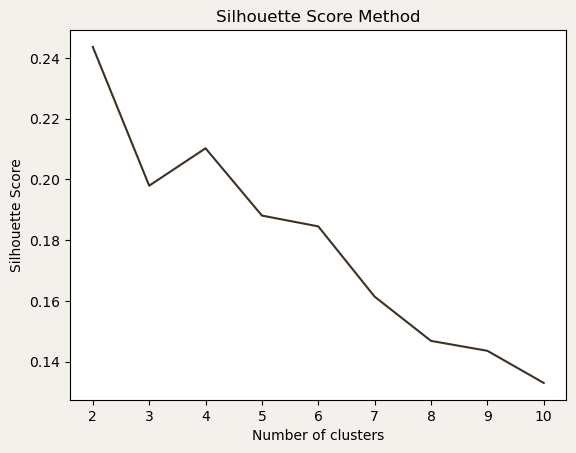

In [36]:
# Drop the non numeric cloumn for calculations
toronto_onehot_grouped_clustering = toronto_onehot_grouped.drop('Postal Code', axis=1)

# Use your DataFrame's data
X = toronto_onehot_grouped_clustering

# Silhouette Score
silhouette_scores = []
for i in range(2, 11):  # Silhouette score is not defined for a single cluster
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    score = silhouette_score(X, kmeans.labels_)
    silhouette_scores.append(score)

# Plot the Silhouette Scores
fig, ax = plt.subplots()
fig.patch.set_facecolor('#F4F0EC')  # Set the face color of the figure
ax.plot(range(2, 11), silhouette_scores, color='#3e3023')  # Set the color of the plotted line
ax.set_title('Silhouette Score Method')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette Score')
plt.show()


In [37]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_onehot_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 1, 0, 1, 1, 3, 3, 3, 3, 1])

 <div style="background-color: #6a513b; padding: 10px;">
  <p style="color: #e0d3c7;" >9.8 - Create a DataFrame that contains the cluster labels, original data, and the top 10 most common Place Types for each postal code.</p>
  <ul>
    <li style="color: #e0d3c7;">Add the cluster labels to the toronto_onehot_sorted DataFrame.</li>
    <li style="color: #e0d3c7;">Create a copy of the original DataFrame.</li>
    <li style="color: #e0d3c7;">Merges the two DataFrames.</li>
  </ul>
</div>

In [38]:
# add clustering labels
toronto_onehot_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_onehot_merged = toronto_data_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_onehot_merged = toronto_onehot_merged.join(toronto_onehot_sorted.set_index('Postal Code'), on='Postal Code', how='right')

toronto_onehot_merged.head() # check the last columns!

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Population,Average Income,Cafe Counts,Cafe Names,Cluster Labels,1st Most Common Place Type,2nd Most Common Place Type,3rd Most Common Place Type,4th Most Common Place Type,5th Most Common Place Type,6th Most Common Place Type,7th Most Common Place Type,8th Most Common Place Type,9th Most Common Place Type,10th Most Common Place Type
0,M1B,Scarborough,Malvern / Rouge,43.8113,-79.1930,65555.0,69126.0,0,NaN,2,establishment,store,food,electronics_store,accounting,car_repair,lodging,general_contractor,park,furniture_store
1,M1C,Scarborough,Rouge Hill / Port Union / Highland Creek,43.7878,-79.1564,35642.0,109785.0,0,NaN,1,transit_station,establishment,finance,gas_station,car_repair,general_contractor,accounting,car_wash,hair_care,real_estate_agency
2,M1E,Scarborough,Guildwood / Morningside / West Hill,43.7678,-79.1866,48033.0,62047.0,4,"Tim Hortons, Eggsmart, McDonald's, Mr. Puffs",0,establishment,finance,restaurant,store,health,accounting,bank,electronics_store,spa,sublocality_level_1
3,M1G,Scarborough,Woburn,43.7712,-79.2144,30894.0,54450.0,0,NaN,1,establishment,transit_station,health,hair_care,finance,store,primary_school,convenience_store,moving_company,insurance_agency
4,M1H,Scarborough,Cedarbrae,43.7686,-79.2389,23964.0,58492.0,0,NaN,1,establishment,transit_station,park,primary_school,church,school,health,sublocality_level_1,laundry,travel_agency


 <div style="background-color: #6a513b; padding: 10px;">
  <p style="color: #e0d3c7;" >9.9 - Create the final Data frame using the toronto_onehot_merged, drop the columns not necessary for conclusion and discussion.</p>
</div>

In [39]:
toronto_final = toronto_onehot_merged.drop(['Latitude', 'Longitude', 'Cafe Names'], axis= 1)

<div style="background-color: #6a513b; padding: 10px;">
  <h1 style="color: #d4c2b2;border-bottom: 2px solid Azure;">Lets Print all the 6 Clusters and And Analyze their characteristic </h1>
  <h1 style="color: #d4c2b2;">Cluster A </h1>
</div>

In [40]:
ClusterA = toronto_final.loc[toronto_final['Cluster Labels'] == 0, toronto_final.columns[[0] + [1] + [2] + [3] + [4] + list(range(5, toronto_final.shape[1]))]]
ClusterA = ClusterA.drop(['Cluster Labels'], axis = 1).reset_index(drop= True)

ClusterA

,Postal Code,Borough,Neighborhood,Population,Average Income,Cafe Counts,1st Most Common Place Type,2nd Most Common Place Type,3rd Most Common Place Type,4th Most Common Place Type,5th Most Common Place Type,6th Most Common Place Type,7th Most Common Place Type,8th Most Common Place Type,9th Most Common Place Type,10th Most Common Place Type
0,M1E,Scarborough,Guildwood / Morningside / West Hill,48033.0,62047.0,4,establishment,finance,restaurant,store,health,accounting,bank,electronics_store,spa,sublocality_level_1
1,M1T,Scarborough,Clarks Corners / Tam O'Shanter / Sullivan,34607.0,53535.0,1,establishment,finance,health,dentist,store,lawyer,gas_station,general_contractor,accounting,restaurant
2,M1W,Scarborough,Steeles West / L'Amoreaux West,47070.0,65190.0,1,establishment,store,dentist,restaurant,bank,transit_station,beauty_salon,health,meal_takeaway,park
3,M1X,Scarborough,Upper Rouge,14810.0,96107.0,0,locality,sublocality_level_1,accounting,moving_company,physiotherapist,pharmacy,pet_store,parking,park,painter
4,M2J,North York,Fairview / Henry Farm / Oriole,61761.0,63471.0,9,clothing_store,establishment,shoe_store,health,dentist,store,church,food,finance,electronics_store
5,M2N,North York,Willowdale,75100.0,62919.0,15,establishment,lawyer,restaurant,bank,store,lodging,local_government_office,pharmacy,physiotherapist,dentist
6,M3N,North York,Downsview,40846.0,47650.0,6,health,establishment,doctor,restaurant,store,meal_delivery,physiotherapist,finance,supermarket,clothing_store
7,M4G,East York,Leaside,19598.0,115833.0,4,establishment,store,real_estate_agency,health,restaurant,finance,beauty_salon,bicycle_store,gym,hair_care
8,M4H,East York,Thorncliffe Park,18698.0,43945.0,3,establishment,store,restaurant,finance,clothing_store,accounting,hospital,health,real_estate_agency,primary_school
9,M4K,East Toronto,The Danforth West / Riverdale,30913.0,65948.0,13,health,establishment,restaurant,clothing_store,store,travel_agency,laundry,spa,gym,food


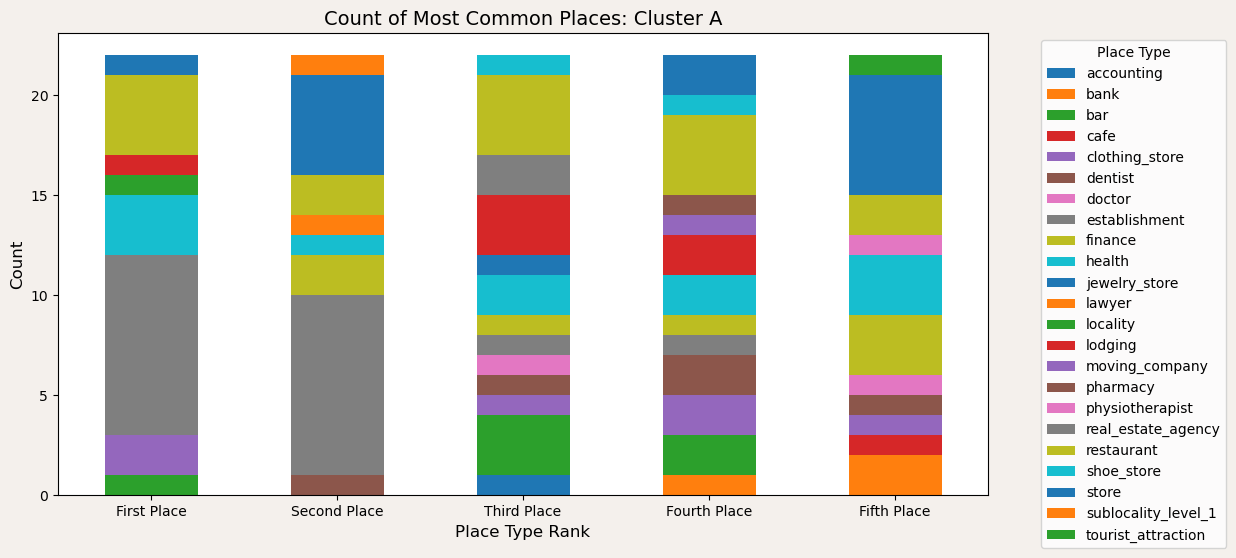

In [41]:
# Count of most common Place Types
Place_Type_columns = ['1st Most Common Place Type', '2nd Most Common Place Type', '3rd Most Common Place Type', '4th Most Common Place Type','5th Most Common Place Type']
Place_Type_counts = ClusterA[Place_Type_columns].apply(pd.Series.value_counts).fillna(0)

# Custom labels for the x-axis
custom_labels = ['First Place', 'Second Place', 'Third Place', 'Fourth Place', 'Fifth Place']

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('#F4F0EC')  # Set the face color of the figure
Place_Type_counts.T.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Count of Most Common Places: Cluster A', fontsize=14)
ax.set_ylabel('Count', fontsize=12)
ax.set_xlabel('Place Type Rank', fontsize=12)
ax.set_xticklabels(custom_labels, rotation=-0)
ax.legend(title='Place Type', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


<div style="background-color: #6a513b; padding: 10px;">
   <h1 style="color: #d4c2b2;">Cluster B </h1>
</div>

In [42]:
ClusterB = toronto_final.loc[toronto_final['Cluster Labels'] == 1, toronto_final.columns[[0] + [1] + [2] + [3] + [4] + list(range(5, toronto_final.shape[1]))]]
ClusterB = ClusterB.drop(['Cluster Labels'], axis = 1).reset_index(drop= True)

ClusterB

,Postal Code,Borough,Neighborhood,Population,Average Income,Cafe Counts,1st Most Common Place Type,2nd Most Common Place Type,3rd Most Common Place Type,4th Most Common Place Type,5th Most Common Place Type,6th Most Common Place Type,7th Most Common Place Type,8th Most Common Place Type,9th Most Common Place Type,10th Most Common Place Type
0,M1C,Scarborough,Rouge Hill / Port Union / Highland Creek,35642.0,109785.0,0,transit_station,establishment,finance,gas_station,car_repair,general_contractor,accounting,car_wash,hair_care,real_estate_agency
1,M1G,Scarborough,Woburn,30894.0,54450.0,0,establishment,transit_station,health,hair_care,finance,store,primary_school,convenience_store,moving_company,insurance_agency
2,M1H,Scarborough,Cedarbrae,23964.0,58492.0,0,establishment,transit_station,park,primary_school,church,school,health,sublocality_level_1,laundry,travel_agency
3,M1N,Scarborough,Birch Cliff / Cliffside West,22976.0,73256.0,2,establishment,transit_station,church,school,park,restaurant,electronics_store,local_government_office,home_goods_store,plumber
4,M1V,Scarborough,Milliken / Agincourt North / Steeles East / L'...,50825.0,64576.0,0,transit_station,establishment,health,roofing_contractor,car_repair,church,finance,physiotherapist,pharmacy,primary_school
5,M2H,North York,Hillcrest Village,23396.0,72220.0,0,transit_station,establishment,park,school,electrician,store,meal_takeaway,health,general_contractor,florist
6,M2M,North York,Willowdale / Newtonbrook,31915.0,60440.0,0,establishment,transit_station,general_contractor,church,store,health,moving_company,accounting,spa,lawyer
7,M3A,North York,Parkwoods,34361.0,64761.0,0,establishment,transit_station,real_estate_agency,store,beauty_salon,school,general_contractor,locality,convenience_store,roofing_contractor
8,M3K,North York,Downsview,7865.0,62635.0,0,establishment,transit_station,amusement_park,locality,electrician,beauty_salon,sublocality_level_1,park,roofing_contractor,neighborhood
9,M3L,North York,Downsview,19263.0,59669.0,0,establishment,transit_station,park,accounting,car_repair,lodging,home_goods_store,health,food,plumber


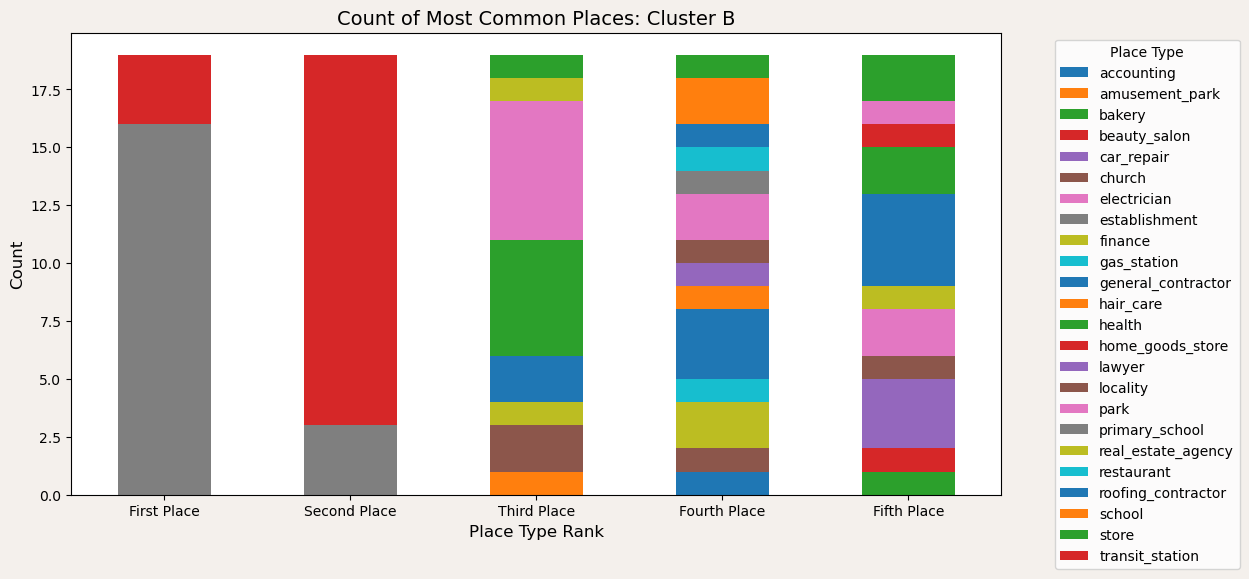

In [43]:
# Count of most common Place Types
Place_Type_columns = ['1st Most Common Place Type', '2nd Most Common Place Type', '3rd Most Common Place Type', '4th Most Common Place Type','5th Most Common Place Type']
Place_Type_counts = ClusterB[Place_Type_columns].apply(pd.Series.value_counts).fillna(0)

# Custom labels for the x-axis
custom_labels = ['First Place', 'Second Place', 'Third Place', 'Fourth Place', 'Fifth Place']

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('#F4F0EC')  # Set the face color of the figure
Place_Type_counts.T.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Count of Most Common Places: Cluster B', fontsize=14)
ax.set_ylabel('Count', fontsize=12)
ax.set_xlabel('Place Type Rank', fontsize=12)
ax.set_xticklabels(custom_labels, rotation=-0)
ax.legend(title='Place Type', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


<div style="background-color: #6a513b; padding: 10px;">
   <h1 style="color: #d4c2b2;">Cluster C </h1>
</div>

In [44]:
ClusterC = toronto_final.loc[toronto_final['Cluster Labels'] == 2, toronto_final.columns[[0] + [1] + [2] + [3] + [4] + list(range(5, toronto_final.shape[1]))]]
ClusterC = ClusterC.drop(['Cluster Labels'], axis = 1).reset_index(drop= True)

ClusterC

,Postal Code,Borough,Neighborhood,Population,Average Income,Cafe Counts,1st Most Common Place Type,2nd Most Common Place Type,3rd Most Common Place Type,4th Most Common Place Type,5th Most Common Place Type,6th Most Common Place Type,7th Most Common Place Type,8th Most Common Place Type,9th Most Common Place Type,10th Most Common Place Type
0,M1B,Scarborough,Malvern / Rouge,65555.0,69126.0,0,establishment,store,food,electronics_store,accounting,car_repair,lodging,general_contractor,park,furniture_store
1,M1P,Scarborough,Dorset Park / Wexford Heights / Scarborough To...,45170.0,56661.0,1,establishment,store,car_repair,general_contractor,health,electronics_store,hindu_temple,furniture_store,food,electrician
2,M1S,Scarborough,Agincourt,37663.0,63376.0,0,establishment,transit_station,store,general_contractor,real_estate_agency,health,food,car_repair,electronics_store,home_goods_store
3,M2L,North York,York Mills / Silver Hills,11274.0,115493.0,0,establishment,transit_station,school,secondary_school,general_contractor,locality,primary_school,sublocality_level_1,furniture_store,pet_store
4,M2R,North York,Willowdale,40581.0,56027.0,1,establishment,health,transit_station,doctor,store,car_wash,bus_station,hospital,funeral_home,gas_station
5,M3C,North York,Don Mills,39616.0,57275.0,1,establishment,park,church,finance,transit_station,primary_school,sublocality_level_1,school,florist,general_contractor
6,M4E,East Toronto,The Beaches,25473.0,94587.0,3,establishment,health,store,general_contractor,park,florist,school,gym,secondary_school,home_goods_store
7,M4L,East Toronto,India Bazaar / The Beaches West,32218.0,81014.0,5,establishment,restaurant,general_contractor,park,store,pharmacy,accounting,transit_station,health,meal_delivery
8,M4M,East Toronto,Studio District,25052.0,75412.0,1,establishment,general_contractor,food,health,electrician,beauty_salon,gym,sublocality_level_1,home_goods_store,electronics_store
9,M4R,Central Toronto,North Toronto West,11909.0,94208.0,0,establishment,transit_station,health,school,church,clothing_store,beauty_salon,finance,electronics_store,park


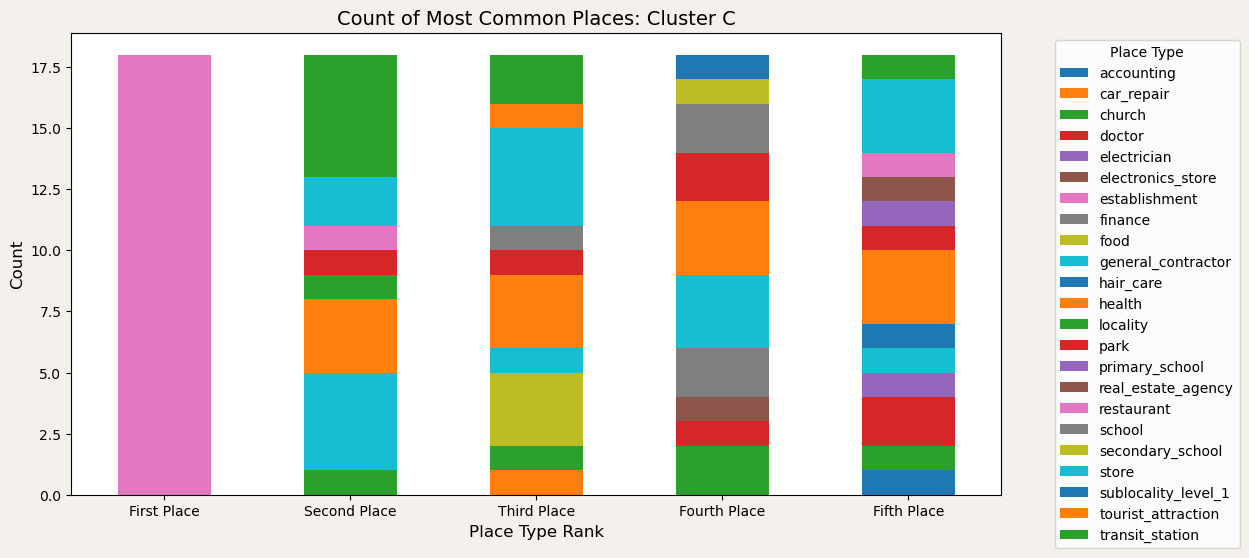

In [45]:
# Count of most common Place Types
Place_Type_columns = ['1st Most Common Place Type', '2nd Most Common Place Type', '3rd Most Common Place Type', '4th Most Common Place Type','5th Most Common Place Type']
Place_Type_counts = ClusterC[Place_Type_columns].apply(pd.Series.value_counts).fillna(0)

# Custom labels for the x-axis
custom_labels = ['First Place', 'Second Place', 'Third Place', 'Fourth Place', 'Fifth Place']

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('#F4F0EC')  # Set the face color of the figure
Place_Type_counts.T.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Count of Most Common Places: Cluster C', fontsize=14)
ax.set_ylabel('Count', fontsize=12)
ax.set_xlabel('Place Type Rank', fontsize=12)
ax.set_xticklabels(custom_labels, rotation=-0)
ax.legend(title='Place Type', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

<div style="background-color: #6a513b; padding: 10px;">
   <h1 style="color: #d4c2b2;">Cluster D </h1>
</div>

In [46]:
ClusterD = toronto_final.loc[toronto_final['Cluster Labels'] == 3, toronto_final.columns[[0] + [1] + [2] + [3] + [4] + list(range(5, toronto_final.shape[1]))]]
ClusterD = ClusterD.drop(['Cluster Labels'], axis = 1).reset_index(drop= True)

ClusterD

,Postal Code,Borough,Neighborhood,Population,Average Income,Cafe Counts,1st Most Common Place Type,2nd Most Common Place Type,3rd Most Common Place Type,4th Most Common Place Type,5th Most Common Place Type,6th Most Common Place Type,7th Most Common Place Type,8th Most Common Place Type,9th Most Common Place Type,10th Most Common Place Type
0,M1J,Scarborough,Scarborough Village,37002.0,54507.0,0,establishment,transit_station,restaurant,general_contractor,finance,car_wash,moving_company,clothing_store,hair_care,primary_school
1,M1K,Scarborough,Kennedy Park / Ionview / East Birchmount Park,48175.0,53260.0,1,establishment,dentist,health,church,finance,school,pharmacy,restaurant,accounting,transit_station
2,M1L,Scarborough,Golden Mile / Clairlea / Oakridge,35833.0,56779.0,2,establishment,transit_station,health,store,general_contractor,cafe,spa,church,hospital,electrician
3,M1M,Scarborough,Cliffside / Cliffcrest / Scarborough Village West,23258.0,68550.0,1,establishment,store,dentist,general_contractor,bank,health,finance,meal_delivery,lodging,church
4,M1R,Scarborough,Wexford / Maryvale,30467.0,60881.0,0,establishment,transit_station,health,dentist,beauty_salon,store,school,general_contractor,primary_school,electrician
5,M2K,North York,Bayview Village,25377.0,68015.0,0,establishment,general_contractor,park,school,church,car_wash,health,plumber,locality,doctor
6,M2P,North York,York Mills West,7546.0,107520.0,0,establishment,health,transit_station,general_contractor,finance,convenience_store,beauty_salon,school,jewelry_store,real_estate_agency
7,M3B,North York,Don Mills,12880.0,108267.0,0,establishment,health,finance,general_contractor,transit_station,store,school,pharmacy,primary_school,church
8,M3H,North York,Bathurst Manor / Wilson Heights / Downsview North,38416.0,71558.0,1,establishment,health,general_contractor,insurance_agency,synagogue,clothing_store,store,beauty_salon,church,real_estate_agency
9,M3J,North York,Northwood Park / York University,26600.0,54031.0,1,establishment,transit_station,restaurant,hair_care,store,school,car_dealer,food,home_goods_store,spa


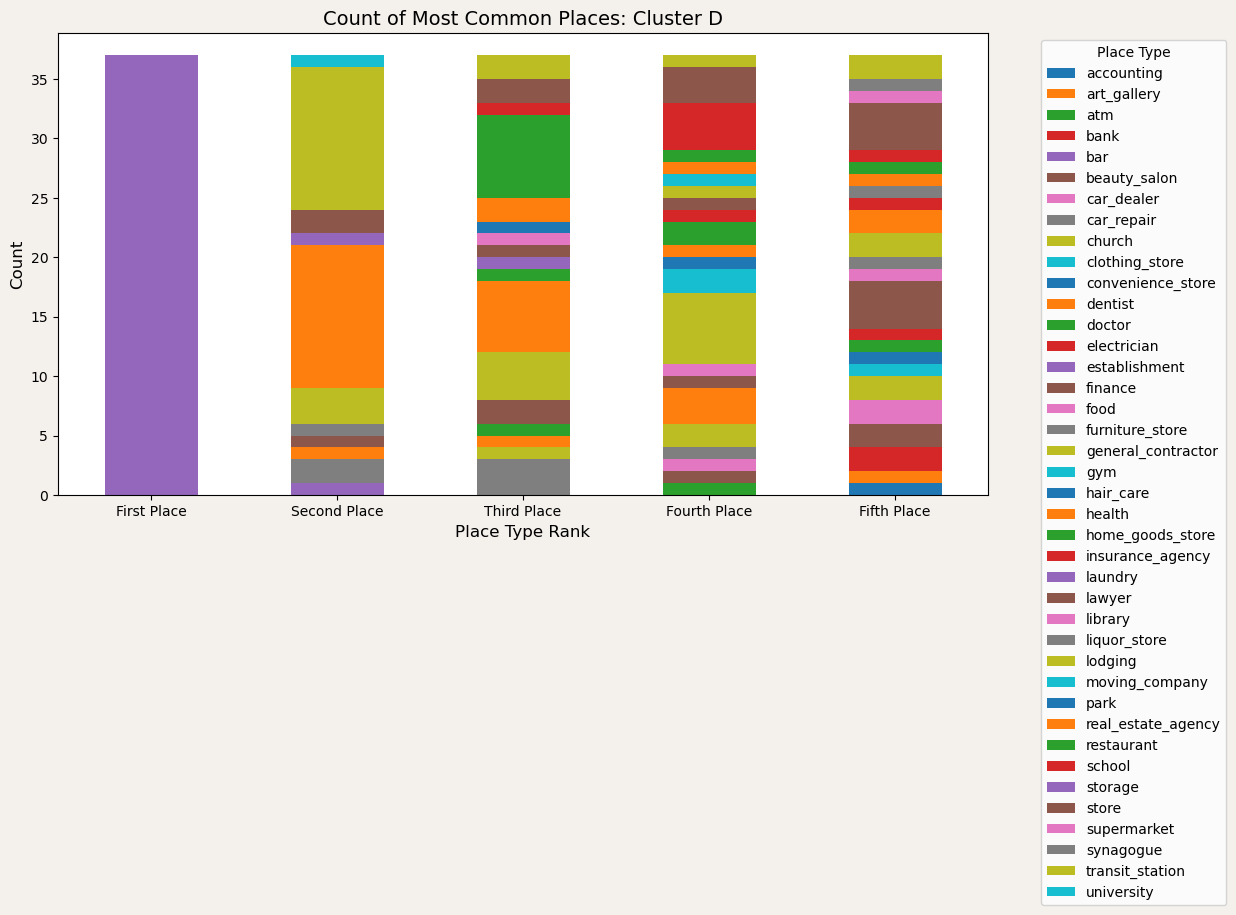

In [47]:
# Count of most common Place Types
Place_Type_columns = ['1st Most Common Place Type', '2nd Most Common Place Type', '3rd Most Common Place Type', '4th Most Common Place Type','5th Most Common Place Type']
Place_Type_counts = ClusterD[Place_Type_columns].apply(pd.Series.value_counts).fillna(0)

# Custom labels for the x-axis
custom_labels = ['First Place', 'Second Place', 'Third Place', 'Fourth Place', 'Fifth Place']

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('#F4F0EC')  # Set the face color of the figure
Place_Type_counts.T.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Count of Most Common Places: Cluster D', fontsize=14)
ax.set_ylabel('Count', fontsize=12)
ax.set_xlabel('Place Type Rank', fontsize=12)
ax.set_xticklabels(custom_labels, rotation=-0)
ax.legend(title='Place Type', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

<div style="background-color: #6a513b; padding: 10px;">
   <h1 style="color: #d4c2b2;border-bottom: 2px solid Azure;">Discussion and Conclusion</h1>
</div>
<div style="background-color: #f4f0ec; padding: 20px; border-radius: 10px; color: #d4c2b2; max-width: 1200px; margin: 40px auto; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1); font-family: Arial, sans-serif; display: flex; align-items: center; overflow: auto;">
    <div style="text-align: left; padding: 10px; border: 2px solid #d4c2b2; border-radius: 10px; height: 100px; font-size: 16px; min-width: 150px;background-color: #6a513b;justify-content: center;">
        <h3 style="font-size: 18px;">Inspect each cluster and determine its characteristics</h3>
    </div>
    <div style="font-size: 24px; color: #d4c2b2;">→</div>
    <div style="text-align: left; padding: 10px; border: 2px solid #d4c2b2; border-radius: 10px; height: 100px; font-size: 16px;  min-width: 150px;background-color: #6a513b;justify-content: center;">
        <h3 style="font-size: 18px;">Only select those clusters that support cafe business, move forward</h3>
    </div>
    <div style="font-size: 24px; color: #d4c2b2;">→</div>
    <div style="text-align: left; padding: 10px; border: 2px solid #d4c2b2; border-radius: 10px; height: 100px; font-size: 16px;  min-width: 150px;background-color: #6a513b;justify-content: center;">
        <h3 style="font-size: 18px;">Count cafes in postal codes among the selected clusters</h3>
    </div>
    <div style="font-size: 24px; color: #d4c2b2;">→</div>
    <div style="text-align: left; padding: 10px; border: 2px solid #d4c2b2; border-radius: 10px; height: 100px; font-size: 16px;  min-width: 150px;background-color: #6a513b;justify-content: center;">
        <h3 style="font-size: 18px;">Only select the clusters with low competition, move forward</h3>
    </div>
    <div style="font-size: 24px; color: #d4c2b2;">→</div>
    <div style="text-align: left; padding: 10px; border: 2px solid #d4c2b2; border-radius: 10px; height: 100px; font-size: 16px;  min-width: 150px;background-color: #6a513b;justify-content: center;">
        <h3 style="font-size: 18px;">Inspect the population and income indicators for the selected clusters</h3>
    </div>
    <div style="font-size: 24px; color: #d4c2b2;">→</div>
    <div style="text-align: left; padding: 10px; border: 2px solid #d4c2b2; border-radius: 10px; height: 100px; font-size: 16px;  min-width: 150px;background-color: #6a513b;justify-content: center;">
        <h3 style="font-size: 18px;">Pick up the best postal codes with high income and high population</h3>
    </div>
</div>

<div style="background-color: #6a513b; padding: 10px;">
  <h3 style="color: #e0d3c7;">Data-backed Cluster Characteristics Definition</h3>
  <ul>
    <li style="color: #e0d3c7; font-size: 20px;">Cluster A: </li></br>
    <li style="color: #e0d3c7; font-size: 20px;">Cluster A: </li></br>
    <li style="color: #e0d3c7; font-size: 20px;">Cluster A: </li></br>
    <li style="color: #e0d3c7; font-size: 20px;">Cluster A: </li></br>
  </ul>
</div>

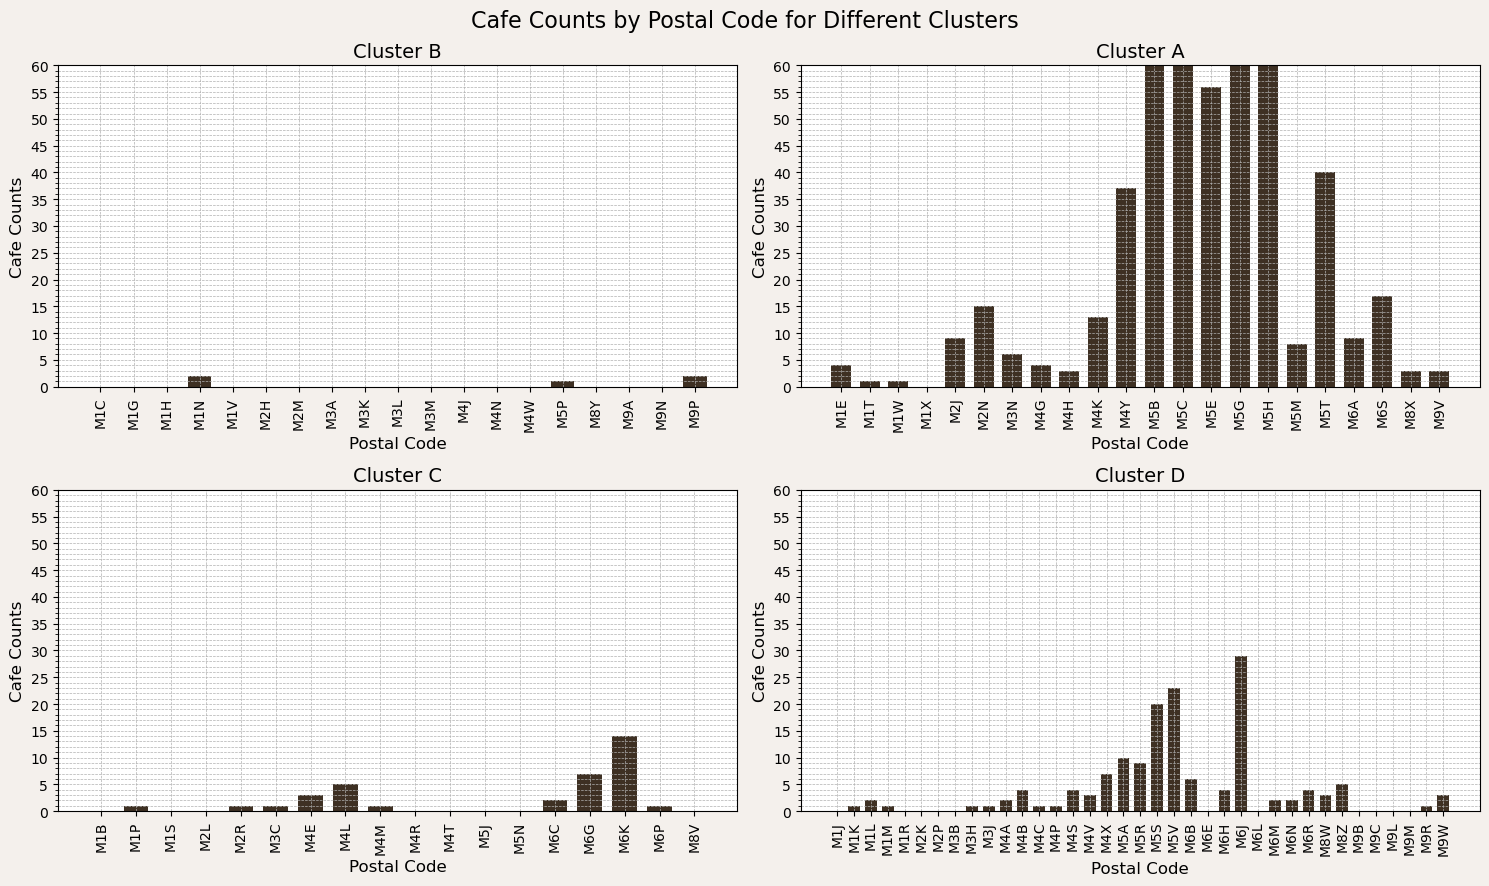

In [48]:
# List of dataframes and their labels
dataframes = [ClusterB, ClusterA, ClusterC, ClusterD]
labels = ['Cluster B', 'Cluster A', 'Cluster C', 'Cluster D']

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 9))
fig.patch.set_facecolor('#F4F0EC')  # Set the face color of the figure

# Plot each dataframe in a separate subplot
for i, df in enumerate(dataframes):
    row = i // 2
    col = i % 2
    axs[row, col].bar(df['Postal Code'], df['Cafe Counts'], color='#3e3023', width=0.7)  # Set the width of the bars
    axs[row, col].set_title(labels[i], fontsize=14)
    axs[row, col].set_ylabel('Cafe Counts', fontsize=12)
    axs[row, col].set_xlabel('Postal Code', fontsize=12)
    axs[row, col].set_xticklabels(df['Postal Code'], rotation=90)
    axs[row, col].set_ylim(0, 60)  # Set the y-axis scale from 0 to 60
    axs[row, col].grid(True, which='both', linestyle='--', linewidth=0.5)  # Add a dense grid
    axs[row, col].yaxis.set_major_locator(ticker.MultipleLocator(5))  # Set y-axis labels distance to 5
    axs[row, col].yaxis.set_minor_locator(ticker.MultipleLocator(1))  # Set grid distance to 1

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
fig.suptitle('Cafe Counts by Postal Code for Different Clusters', fontsize=16)
plt.show()

<div style="background-color: #6a513b; padding: 10px; text-align: center;">
  <h2 style="color: #e0d3c7;">Results and recommendation</h2>
  <ul>
    <li style="color: #e0d3c7; font-size: 20px;text-align: left;">Choice 1: It will be profitable for the business to open a new cafe in the neighborhoods of _______________, as we see that the business market characteristics here is __________, the population of this area is _____________ which is above the toronto's median population of _____________ and the median household income of __________ is above the toronto's median population of _____________</li></br>
    <li style="color: #e0d3c7; font-size: 20px;text-align: left;">Choice 2: It will be profitable for the business to open a new cafe in the neighborhoods of _______________, as we see that the business market characteristics here is __________, the population of this area is _____________ which is above the toronto's median population of _____________ and the median household income of __________ is above the toronto's median population of _____________</li></br>
    <li style="color: #e0d3c7; font-size: 20px;text-align: left;">Choice 3: It will be profitable for the business to open a new cafe in the neighborhoods of _______________, as we see that the business market characteristics here is __________, the population of this area is _____________ which is above the toronto's median population of _____________ and the median household income of __________ is above the toronto's median population of _____________</li></br>
  </ul>
</div>

<div style="background-color: #6a513b; padding: 10px; text-align: center;">
  <h3 style="color: #e0d3c7; text-decoration: underline;">
    <a href="https://www.figma.com/deck/905lRluzTIGOObcbZH7hUI/Untitled?node-id=1-434&node-type=slide&t=AS2BuytWmwhCpHQ7-0&scaling=min-zoom&content-scaling=fixed&page-id=0%3A1" target="_blank" style="color: #e0d3c7;">Link to the Project Presentation</a>
  </h3>
</div>